# Canadian Community Wellbeing Index

Created by Jordan Meyer

In [3]:
#import folium (mapping) and geopy (lat/long coordinate retrieval)

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total: 

In [6]:
#import Libraries required for analysis

import pandas as pd
import numpy as np

import numpy as np
import pandas as pd 

import json

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans

from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


In [2]:
#import Community Wellbeing Index (2016) from the Canadian Government's database of open datasets

df = pd.read_csv("https://www.sac-isc.gc.ca/DAM/DAM-ISC-SAC/DAM-STSCRD/STAGING/texte-text/CWB_2016_DATA_1557324628212_eng.csv", encoding = 'latin-1')
df.head()

,CSD Code / Code de la SDR 2016,CSD Name / Nom de la SDR 2016,Census Population / Population de recensement 2016,Income / Revenu 2016,Education / Scolarité 2016,Housing / Logement 2016,Labour Force Activity / Activité sur le marché du travail 2016,CWB / IBC 2016,Community Type / Type de communauté 2016
0,1001101,"Division No. 1, Subd. V",36.0,NaN,NaN,NaN,NaN,NaN,Non-Indigenous Community / Communauté non-Auto...
1,1001105,Portugal Cove South,150.0,NaN,NaN,NaN,NaN,73.0,Non-Indigenous Community / Communauté non-Auto...
2,1001113,Trepassey,481.0,80.0,50.0,98.0,70.0,74.0,Non-Indigenous Community / Communauté non-Auto...
3,1001120,St. Shott's,66.0,NaN,NaN,NaN,NaN,77.0,Non-Indigenous Community / Communauté non-Auto...
4,1001124,"Division No. 1, Subd. U",1625.0,81.0,60.0,97.0,80.0,80.0,Non-Indigenous Community / Communauté non-Auto...


In [25]:
df.shape

(5162, 9)

## Clean the Dataset

1. Drop communities with any missing data
2. Drop columns that aren't needed (CSD Code, Aboriginal Status)
3. Rename columns for simplicity


In [3]:
#drop any community with missing index values (replacing NaNs with mean values not the best approach for this dataset)

df = df.dropna()
df.shape

(3680, 9)

In [4]:
#drop unnecessary columns
df = df.drop(columns = ['CSD Code / Code de la SDR 2016'])

In [5]:
#rename the columns
df.rename(columns={
    'CSD Name / Nom de la SDR 2016': 'Community',
    'Census Population / Population de recensement 2016': 'Population',
    'Income / Revenu 2016': 'Income',
    'Education / Scolarité 2016': 'Education',
    'Housing / Logement 2016': 'Housing',
    'Labour Force Activity / Activité sur le marché du travail 2016': 'Labour',
    'CWB / IBC 2016': 'Well_Being_Index',
    'Community Type / Type de communauté 2016': 'Indigenous Community'} , inplace = True)

In [6]:
#convert Indigeneous Community column into binary data, then reset the index

df.replace(regex={'Non-Indigenous Community / Communauté non-Autochtone': 0,
                  'First Nations Community / Communauté des Premières Nations': 1,
                 'Inuit Community / Communauté inuite': 0}, inplace = True)

df = df.reset_index(drop=True)

df.head()

,Community,Population,Income,Education,Housing,Labour,Well_Being_Index,Indigenous Community
0,Trepassey,481.0,80.0,50.0,98.0,70.0,74.0,0
1,"Division No. 1, Subd. U",1625.0,81.0,60.0,97.0,80.0,80.0,0
2,Cape Broyle,489.0,74.0,51.0,96.0,83.0,76.0,0
3,Renews-Cappahayden,301.0,79.0,54.0,98.0,75.0,77.0,0
4,Fermeuse,325.0,80.0,49.0,99.0,77.0,76.0,0


## Explore the Data

Before jumping into detailed analysis, let's get a feel for the data through visualization and high level statistics to capture any *clear cut* trends.

Explore the relationship between:


1. Understand which indexes have the greatest variability.
1. Population vs. Well Being
2. The effect of education on the resulting indexes.
3. Find the index with the greatest variability (standard of deviation) of results

### Understand the distribution of each index

In [10]:
df.describe().round()

,Population,Income,Education,Housing,Labour,Well_Being_Index,Indigenous Community
count,3680.0,3680.0,3680.0,3680.0,3680.0,3680.0,3680.0
mean,9513.0,73.0,54.0,92.0,83.0,75.0,0.0
std,69985.0,10.0,11.0,11.0,9.0,9.0,0.0
min,250.0,15.0,9.0,25.0,41.0,34.0,0.0
25%,591.0,70.0,49.0,93.0,79.0,74.0,0.0
50%,1240.0,74.0,56.0,95.0,85.0,77.0,0.0
75%,3469.0,79.0,61.0,96.0,88.0,80.0,0.0
max,2731571.0,100.0,89.0,100.0,99.0,92.0,1.0


### Visualize the Data

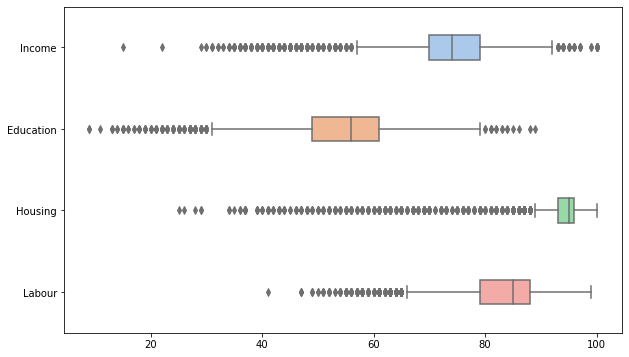

In [11]:
df_data = df.drop(columns = ['Community', 'Population', 'Well_Being_Index', 'Indigenous Community'])

plt.figure(figsize=(10, 6))

ax = sns.boxplot(data=df_data,
                width=0.3,
                palette="pastel",
                orient="h")

plt.savefig('boxplot.png')

A few takeaways from the plots above:

Median Index Ranking (Lowest to Highest)
1. Education
2. Income
3. Labour
4. Housing

This plot illustrates that **education** is lagging relative to all other indexes. 

Further, **housing** generally does not appear to be an issue with a high average index and tight distribution.

### Understand how education plays a role in the other indexes

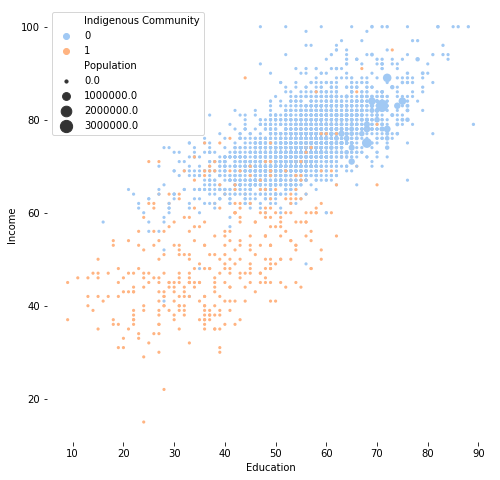

In [12]:
f, ax = plt.subplots(figsize=(8, 8))

sns.despine(f, left=True, bottom=True)

sns.scatterplot(x="Education", y="Income",
                size="Population",
                hue="Indigenous Community",
                palette="pastel",
                sizes=(10, 150),
                linewidth=0,
                data=df,
                ax=ax)

plt.savefig('scatter-eduVSinc.png')

A few observations from the plot above which evaluates the relationship between level of education and the resulting income of the community.

1. A linear relationship is observed between education and income.
2. Indigenous communities represent almost *exclusively* the poorly educated and low income communities in Canada.
3. Major city centres (i.e. large population communities) are generally well educated with a high income level.

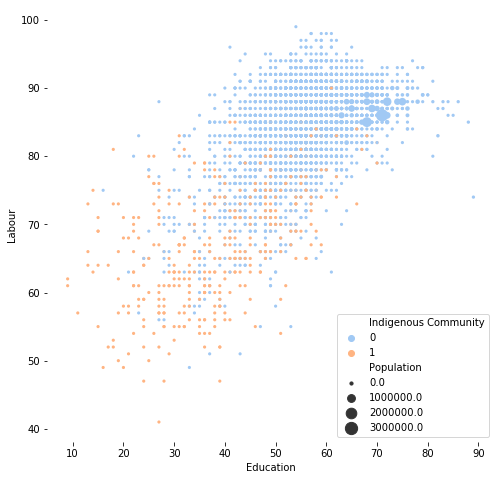

In [13]:
f, ax = plt.subplots(figsize=(8, 8))

sns.despine(f, left=True, bottom=True)

sns.scatterplot(x="Education", y="Labour",
                size="Population",
                hue="Indigenous Community",
                palette="pastel",
                sizes=(10, 150),
                linewidth=0,
                data=df,
                ax=ax)

plt.savefig('scatter-eduVSlab.png')

Again, similar to the relationship between education and income, the labour index above generates similar results. Labour is lineraly related to education, indigeneous communities have poor access to labour, and major city centres are high performers in the labour index.

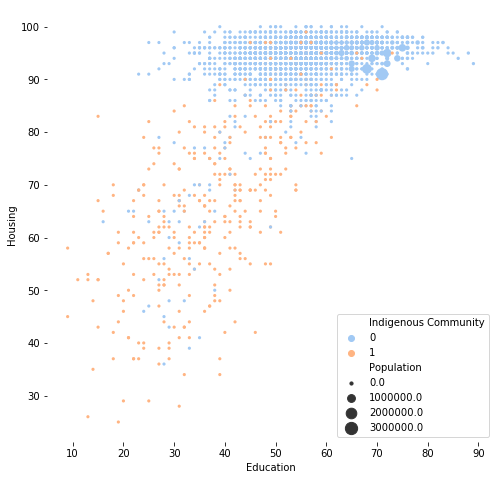

In [14]:
f, ax = plt.subplots(figsize=(8, 8))

sns.despine(f, left=True, bottom=True)

sns.scatterplot(x="Education", y="Housing",
                size="Population",
                hue="Indigenous Community",
                palette="pastel",
                sizes=(10, 150),
                linewidth=0,
                data=df,
                ax=ax)

plt.savefig('scatter-eduVShou.png')

The relationship of education to housing differs from the other two indexes. Here, a linear relationship does not represent the data as accurately. 

One can observe that regardless of education level, most communities in Canada have good access to housing. Only a select number of primarily indigeneous communities have a low housing score.

**Now that we have visualized the data, a couple of decisions will be made to improve our analysis:**

1. We will exclude the major city centres in our analysis, as the city centres rank highly on all indexes and won't be the focus of our report.
2. The need to take a closer look at what's going on in indigeneous communities is clear after visualizing the data. The bottom 50% of all indexes is almost entirely indigenous communities.

### Refine the dataset to Population < 5,000

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


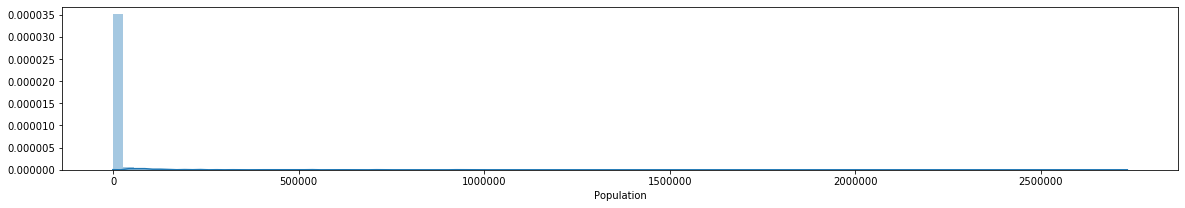

In [32]:
#identify the best way to remove the city centres from the distribution

x = df['Population']

f, ax = plt.subplots(figsize=(20, 3))

sns.distplot(x, bins= 100);

Based on the histogram above, the majority of the communities have less than 5,000 people. We will re-adjust our dataset to only include communities below 5,000 habitants.

In [7]:
df_sub5 = df.loc[df['Population'] < 5000].reset_index(drop=True)

large_communities_removed = df.shape[0] - df_sub5.shape[0]

print("A total of", large_communities_removed, "communities over 5,000 people were removed from the original dataset.")
print("")
print("This leaves a total of", df_sub5.shape[0], "communities remaining.")

A total of 713 communities over 5,000 people were removed from the original dataset.

This leaves a total of 2967 communities remaining.


In [34]:
df_sub5[df_sub5['Indigenous Community']==0].mean()

Population              1395.420217
Income                    74.440356
Education                 54.231991
Housing                   93.930287
Labour                    83.721146
Well_Being_Index          76.577847
Indigenous Community       0.000000
dtype: float64

In [35]:
df_sub5[df_sub5['Indigenous Community']==1].mean()

Population              902.358442
Income                   52.010390
Education                38.932468
Housing                  67.859740
Labour                   67.810390
Well_Being_Index         56.654545
Indigenous Community      1.000000
dtype: float64

### Visualize the Communities with populations below 5,000 based on Indigenous status

Below shows all relationships for each feature in the dataset containing 2,967 communities across Canada with less than 5,000 inhabitants.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


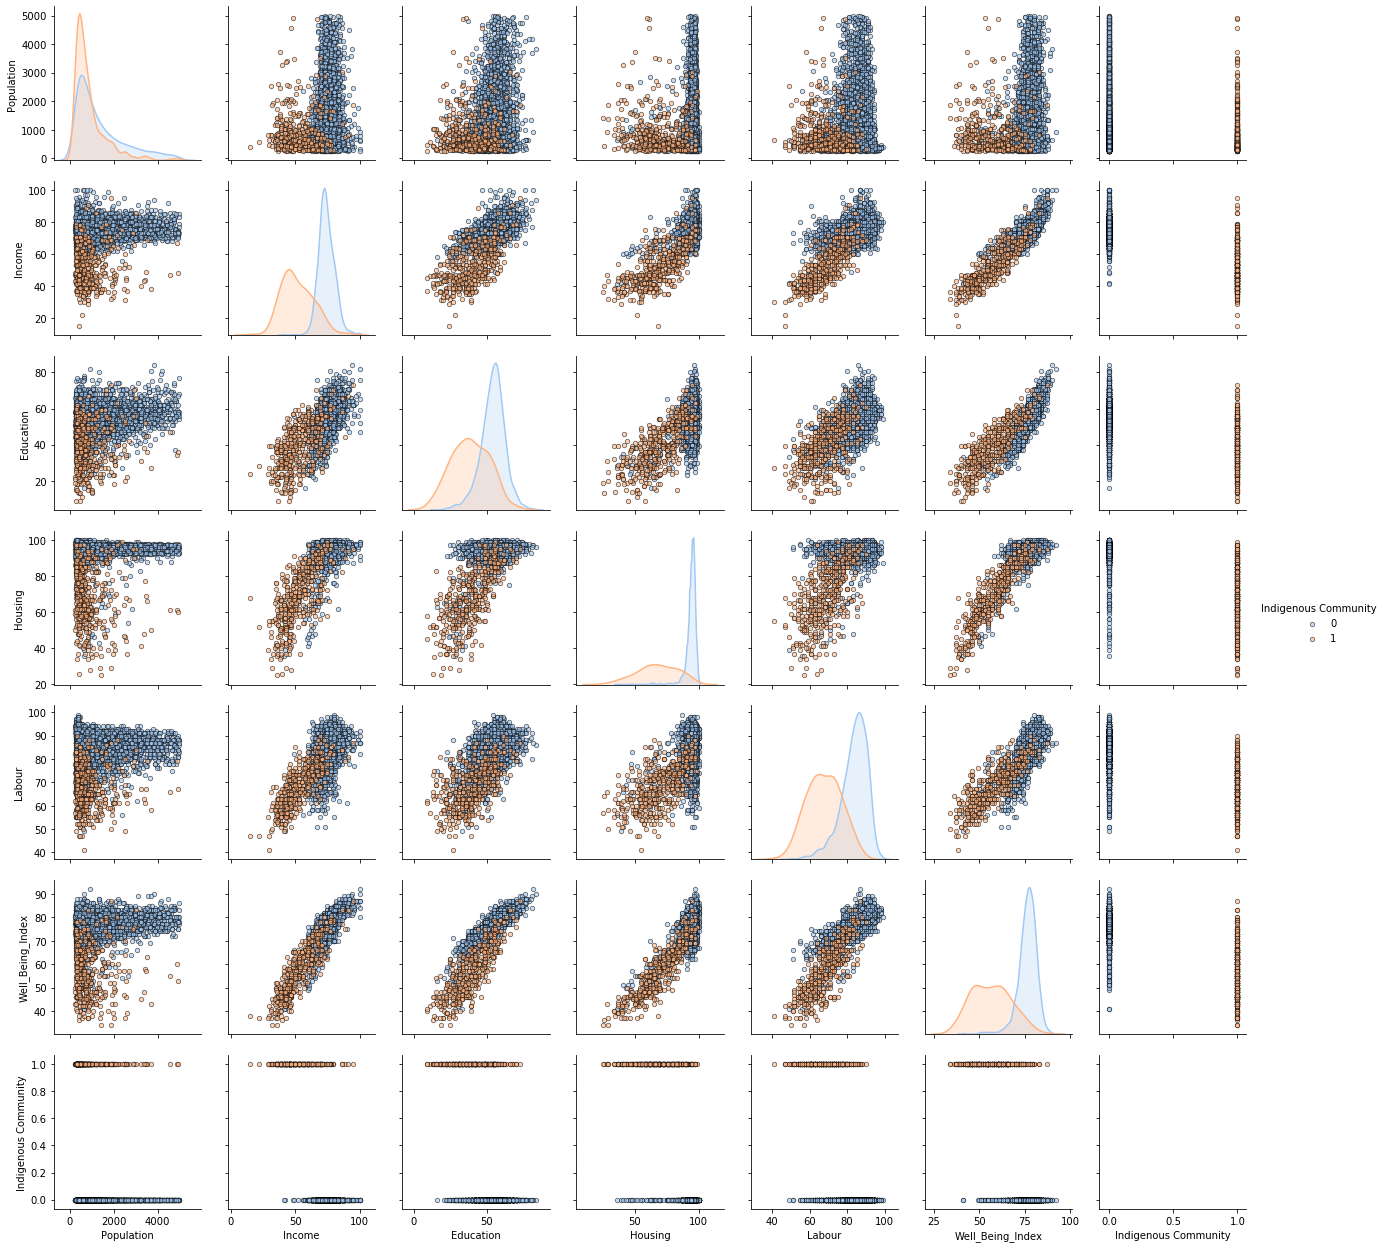

In [17]:
sns.pairplot(df_sub5, 
            hue="Indigenous Community",
            palette="pastel",
            plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor':'k'}
                )

plt.savefig('PairPlot_CommunityType.png')

Wow, this is alot of data. There are some learnings here, but we'll need to take it piece by piece.

First, let's evaluate the diagonal axis. This is the histogram for each variable.

1. Data from indigenous communities has a much wider spread (higher standard of deviation) than non-indigenous communities. 
2. There are only a handful of indigenous communities that have index values comparable to the average of those non-indigenous communities. I wonder what makes them rank highly?

Next, let's look at the 1st column. This is the relationship of population to each feature.

1. If the population of your community is over ~4,000 people, it's almost guaranteed that you have a high standard of living. Said differently, there are no communities with more than 4,000 people that have a wellbeing index below 70. Strength in numbers!
2. There are almost no indigenous communities that have more than 4,000 people.

### Visualize how population plays a role in overall well-being

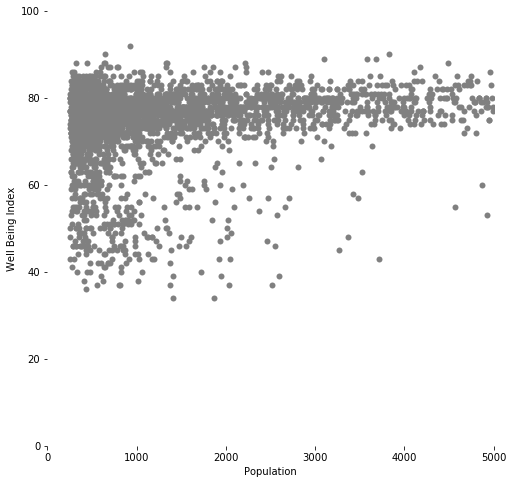

In [18]:
f, ax = plt.subplots(figsize=(8, 8))

sns.despine(f, left=True, bottom=True)

g = sns.scatterplot(x="Population", y="Well_Being_Index",
                palette="pastel",
                sizes=(10, 150),
                linewidth=0,
                data=df_sub5,
                ax=ax,
               color="grey")

g.set(xlim=(0, 5000), xlabel="Population",
      ylim=(0,100), ylabel="Well Being Index")


plt.savefig('scatter-popVSwell_being.png')

## Cluster Communities based on the four Unique Indexes

Based on the four unique indexes (income, education, housing, labour) we will use k-means classification to group the 3,680 communities into four different categories.

In [18]:
df_sub5.head()

,Community,Population,Income,Education,Housing,Labour,Well_Being_Index,Indigenous Community
0,Trepassey,481.0,80.0,50.0,98.0,70.0,74.0,0
1,"Division No. 1, Subd. U",1625.0,81.0,60.0,97.0,80.0,80.0,0
2,Cape Broyle,489.0,74.0,51.0,96.0,83.0,76.0,0
3,Renews-Cappahayden,301.0,79.0,54.0,98.0,75.0,77.0,0
4,Fermeuse,325.0,80.0,49.0,99.0,77.0,76.0,0


In [12]:
df_cluster = df_sub5.drop(columns = ['Community', 'Well_Being_Index'])

df_cluster.head()

,Population,Income,Education,Housing,Labour,Indigenous Community
0,481.0,80.0,50.0,98.0,70.0,0
1,1625.0,81.0,60.0,97.0,80.0,0
2,489.0,74.0,51.0,96.0,83.0,0
3,301.0,79.0,54.0,98.0,75.0,0
4,325.0,80.0,49.0,99.0,77.0,0


In [20]:
df_cluster.astype('float64').dtypes

Population              float64
Income                  float64
Education               float64
Housing                 float64
Labour                  float64
Indigenous Community    float64
dtype: object

In [13]:
#normalize columns in preparation for clustering

min_max_scaler = preprocessing.MinMaxScaler()

cols = df_cluster.columns

np_scaled = min_max_scaler.fit_transform(df_cluster)

df_normalized = pd.DataFrame(np_scaled, columns = cols)

df_normalized.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Population,Income,Education,Housing,Labour,Indigenous Community
0,0.048673,0.764706,0.546667,0.973333,0.500000,0.0
1,0.289718,0.776471,0.680000,0.960000,0.672414,0.0
2,0.050358,0.694118,0.560000,0.946667,0.724138,0.0
3,0.010746,0.752941,0.600000,0.973333,0.586207,0.0
4,0.015803,0.764706,0.533333,0.986667,0.620690,0.0


In [14]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [15]:
# create a new dataframe with the original data and the newly created community clusters

df_sub5_clustered = df_sub5
df_sub5_clustered.insert(7, 'Community Group', kmeans.labels_)

In [24]:
df_sub5_clustered.head()

,Community,Population,Income,Education,Housing,Labour,Well_Being_Index,Community Group,Indigenous Community
0,Trepassey,481.0,80.0,50.0,98.0,70.0,74.0,0,0
1,"Division No. 1, Subd. U",1625.0,81.0,60.0,97.0,80.0,80.0,2,0
2,Cape Broyle,489.0,74.0,51.0,96.0,83.0,76.0,2,0
3,Renews-Cappahayden,301.0,79.0,54.0,98.0,75.0,77.0,0,0
4,Fermeuse,325.0,80.0,49.0,99.0,77.0,76.0,0,0


In [16]:
# before we visualize the clustering results, let's see how many communities are in each cluster

df_sub5_clustered_grouped = df_sub5_clustered.groupby(['Community Group']).count().reset_index()
df_sub5_clustered_grouped.head()

,Community Group,Community,Population,Income,Education,Housing,Labour,Well_Being_Index,Indigenous Community
0,0,654,654,654,654,654,654,654,654
1,1,385,385,385,385,385,385,385,385
2,2,1379,1379,1379,1379,1379,1379,1379,1379
3,3,549,549,549,549,549,549,549,549


### Visualize clustering results of communities with a population below 5,000

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

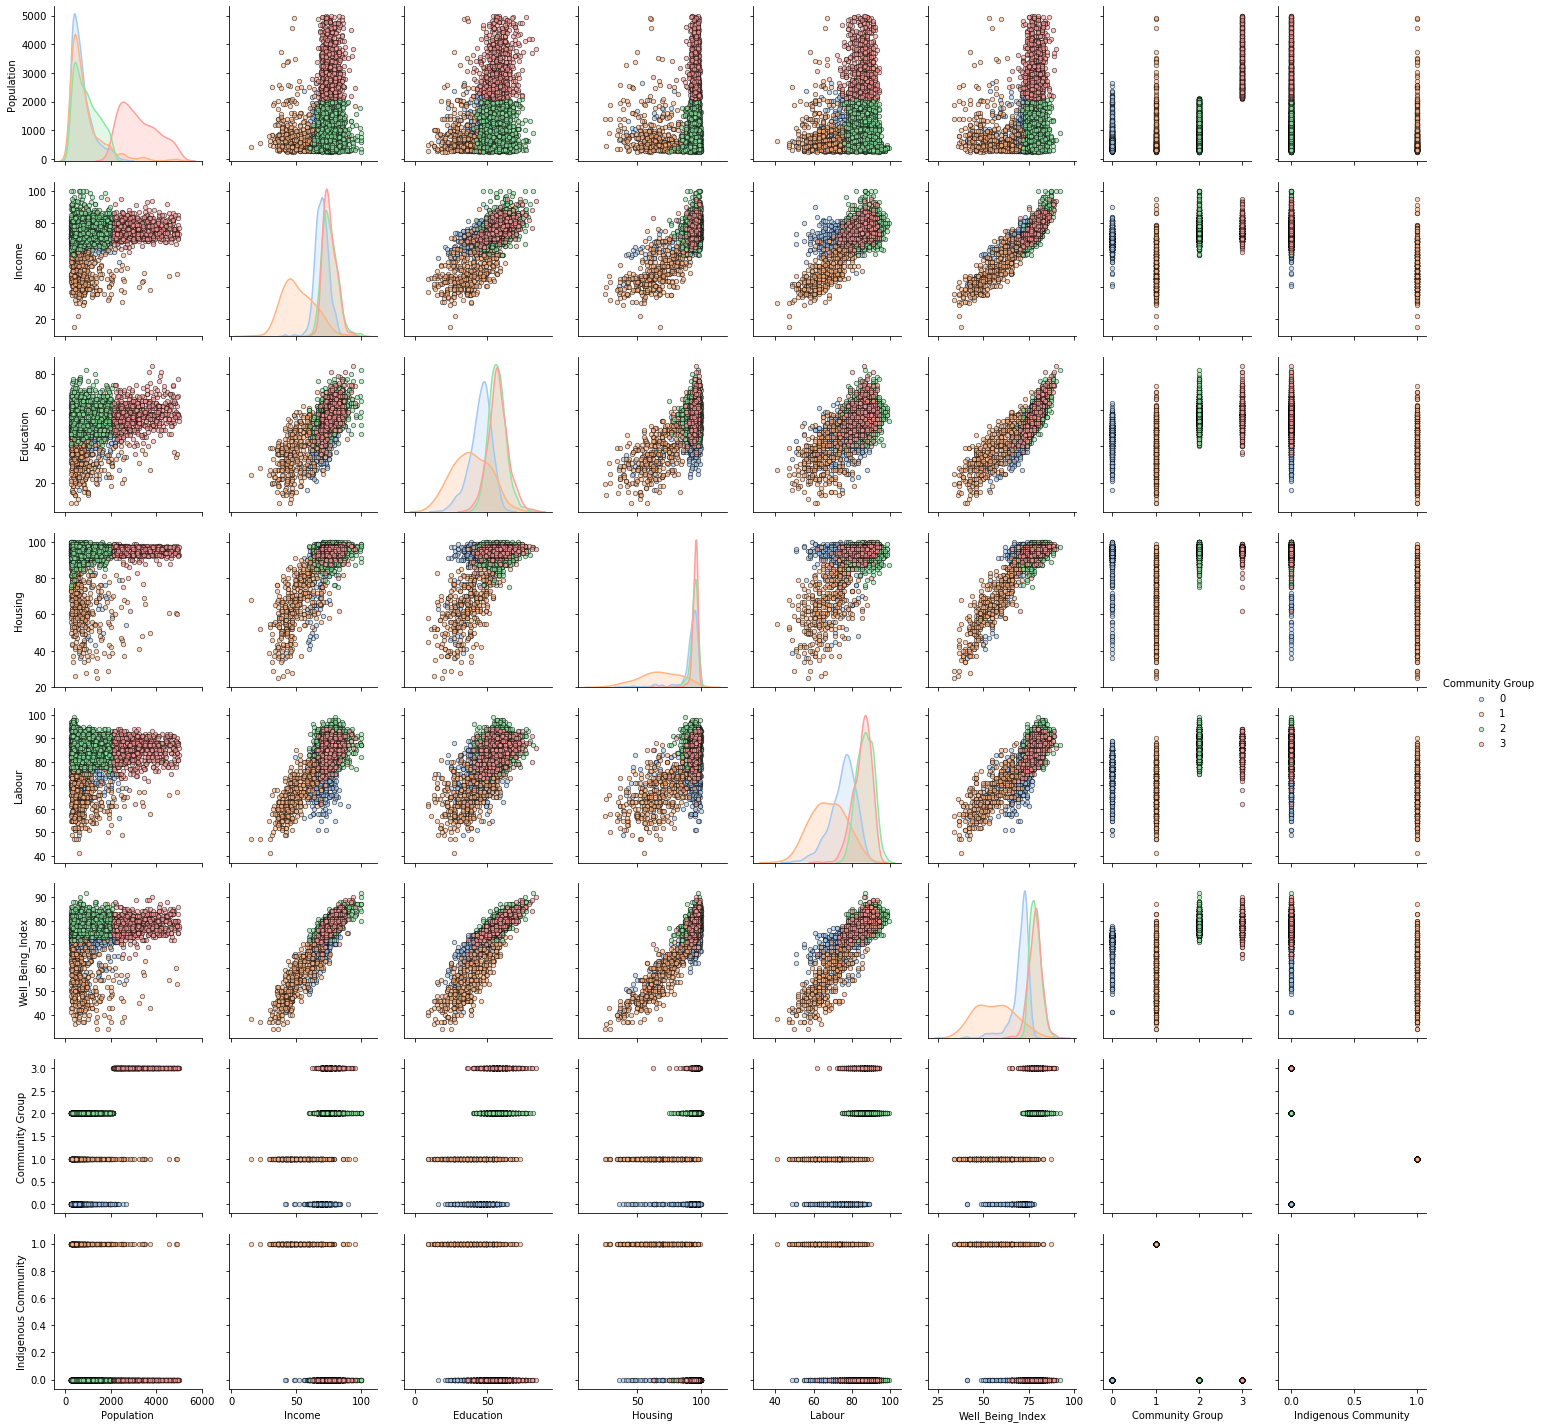

In [26]:
# visualize the how the k-means algorithm has grouped the data  - "Community Grouping"

sns.pairplot(df_sub5_clustered, 
            hue="Community Group",
            palette="pastel",
            plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor':'k'}
                )

plt.savefig('PairPlot_Clusters.png')

Based on the visualization above, we can start to describe each of the unique Community Groups based on the supervised k-means clustering.

**Group 0**
- Population: 0 - 2,000 ("Small")
- Education: Mid
- Income: High
- Housing: High
- Labour: Mid

**Group 1**
- Population 0 - 2,000 ("Small")
- Education: Low
- Income: Low
- Housing: Low
- Labour: Low

**Group 2**
- Population 0 - 2,000 ("Small")
- Education: High
- Income: High
- Housing: High
- Labour: High

**Group 3**
- Population 2,000 - 5,000 ("Big")
- Education: High
- Income: High
- Housing: High
- Labour: High


**Here are the primary takeaways:**
- Group 1 represents the communities with the poorest standards of living in Canada (all of which are small communities)
- Groups 2 & 3 represent the communities with the highest standards of living, split into big (2,000-5,000 habitants) and small (<2,000 habitants)
- Group 0 represents a middle ground

**For the go-forward analysis, we will compare Group 1 (small population, low standard of living) and Group 2 (big population, high standard of living).**

In [17]:
# define two new dataframes - Group 1 (low standard of living) and Group 2 (high standard of living)

df_low = df_sub5_clustered.loc[df_sub5_clustered['Community Group'] == 1].reset_index(drop=True)

df_high = df_sub5_clustered.loc[df_sub5_clustered['Community Group'] == 2].reset_index(drop=True)

In [18]:
print("There are", df_low.shape[0],"communities grouped as having a low standard of living with less than 2,000 habitants.")

print("There are", df_high.shape[0],"communities grouped as having a high standard of living with less than 2,000 habitants.")

There are 385 communities grouped as having a low standard of living with less than 2,000 habitants.
There are 1379 communities grouped as having a high standard of living with less than 2,000 habitants.


## Retrieve Coordinate Information for Each Community

We will employ geopy to retrieve the lat/long coordinates of the newly created dataframes representing low and high standards of living in communities with less than 2,000 habitants.

In [19]:
# initialize blank lat/long columns in preparation for geopy

df_low_loc = df_low
df_high_loc = df_high

df_low_loc['lat'] = ""
df_low_loc['long'] = ""

df_high_loc['lat'] = ""
df_high_loc['long'] = ""

In [30]:
df_high_loc.tail()

,Community,Population,Income,Education,Housing,Labour,Well_Being_Index,Community Group,Indigenous Community,lat,long
1374,Marsh Lake,696.0,86.0,68.0,92.0,88.0,84.0,2,0,,
1375,Macpherson-Grizzly Valley,1245.0,82.0,74.0,94.0,91.0,85.0,2,0,,
1376,"Whitehorse, Unorganized",326.0,89.0,77.0,94.0,91.0,88.0,2,0,,
1377,Norman Wells,778.0,100.0,65.0,89.0,92.0,87.0,2,0,,
1378,"Region 6, Unorganized",302.0,95.0,62.0,87.0,84.0,82.0,2,0,,


In [20]:
# use geopy to retrieve the lat/long coordinates of the communities in the 'low' standard of living group

geolocator = Nominatim(user_agent="canada_explorer")
i = 0

while i < 385:
    address = df_low_loc.loc[i, 'Community']
    location = geolocator.geocode(address)

    if location:
        lat=location.latitude
        long=location.longitude
    else:
        lat = None
        long = None
   
    df_low_loc.loc[i, 'lat'] = lat
    df_low_loc.loc[i, 'long'] = long
    i=i+1

In [ ]:
# export the df_low_loc dataframe to a CSV file, this will prevent us from having to call the geopy function again for lat/long coordinates

export_csv = df_low_loc.to_csv(r'df_low_loc.csv', index = None, header=True)

In [47]:
# use geopy to retrieve the lat/long coordinates of the communities in the 'high' standard of living group

geolocator = Nominatim(user_agent="canada_explorer")
i = 0

while i < 1380:
    address = df_high_loc.loc[i, 'Community']
    location = geolocator.geocode(address)

    if location:
        lat=location.latitude
        long=location.longitude
    else:
        lat = None
        long = None
   
    df_high_loc.loc[i, 'lat'] = lat
    df_high_loc.loc[i, 'long'] = long
    i=i+1

In [48]:
# export the df_low_loc dataframe to a CSV file, this will prevent us from having to call the geopy function again for lat/long coordinates

export_csv = df_high_loc.to_csv(r'df_high_loc.csv', index = None, header=True)

In [7]:
# since Rome wasn't built in a day, let's retrieve the two data frames containing lat/long coordinates that we had previously exported

df_canada_low = pd.read_csv('df_low_loc.csv')
df_canada_high = pd.read_csv('df_high_loc.csv')

In [8]:
# geopy did not find lat/long coordinates for some communities - drop those communities with missing lat/long data

df_canada_low = df_canada_low.dropna()
df_canada_high = df_canada_high.dropna()

In [9]:
# eliminate erroneous geopy lat/long coordinates outside of Canada (constrain lat: 46 to 90, -130 to -50)

df_canada_low = df_canada_low[(df_canada_low['lat'] > 46) &
                            (df_canada_low['lat'] < 90) &
                            (df_canada_low['long'] > -130) &
                            (df_canada_low['long'] < -50)]

df_canada_high = df_canada_high[(df_canada_high['lat'] > 46) &
                            (df_canada_high['lat'] < 90) &
                            (df_canada_high['long'] > -130) &
                            (df_canada_high['long'] < -50)]

In [10]:
print("Group 1 now contains", df_canada_low.shape[0],"communities with a low standard of living.")
print("Group 2 now contains", df_canada_high.shape[0],"communities with a high standard of living.")

Group 1 now contains 212 communities with a low standard of living.
Group 2 now contains 756 communities with a high standard of living.


In [11]:
# for mapping purposes, we will recombine the two dataframes and color by Community Group

df_canada = pd.concat([df_canada_low, df_canada_high])

### Map Canada based on Clusters 1 & 2

In [12]:
# initialize location coordinates for the centre of Canada

latitude = 60.760860
longitude = -98.813873
kclusters = 4

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_canada['lat'], df_canada['long'], df_canada['Community'], df_canada['Community Group']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

This map is very valuable to our analysis. 

First, it's clear that there is no single province in Canada that is immune to communities with low standards of living. These types of communities are spread out across the entire country.

Second, there are several areas of communities in Canada where a community with a high standard of living directly offsets another with a low standard of living. The natural environment they live in is identical, but one community is suffering and the other is not. This will be the focus of our next stage of analysis.

Next, we will draw an area around the map where communities from both ends of the spectrum directly offset one another, in this case, we've chosen North BC as our sample set. These communities will be the building blocks for our Foursquare analysis.

In [13]:
df_centralBC = df_canada

df_centralBC = df_centralBC[(df_centralBC['lat'] > 53) &
                            (df_centralBC['lat'] < 58) &
                            (df_centralBC['long'] > -130) &
                            (df_centralBC['long'] < -125)]

### Map Central BC based on Clusters 1 & 2

In [14]:
# initialize location coordinates for the centre of Canada

latitude = 54.5
longitude = -127
kclusters = 4

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_centralBC['lat'], df_centralBC['long'], df_centralBC['Community'], df_centralBC['Community Group']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

In [39]:
# drop communities with duplicate lat/long coordinates - only need to capture one coordinate for the Foursquare API

df_centralBC = df_centralBC.drop(df_centralBC.index[[9,12,14,15,17]]).reset_index(drop=True)

In [41]:
df_centralBC

,Community,Population,Income,Education,Housing,Labour,Well_Being_Index,Community Group,Indigenous Community,lat,long
0,Garden Hill First Nation,2591.0,37.0,22.0,37.0,61.0,39.0,1,1,55.014209,-127.324086
1,Nisga'a,1880.0,63.0,49.0,72.0,70.0,64.0,1,1,55.010127,-129.003503
2,Kitamaat 2,525.0,69.0,37.0,75.0,68.0,62.0,1,1,53.974875,-128.648185
3,Gitanmaax 1,630.0,60.0,48.0,77.0,74.0,65.0,1,1,55.248863,-127.679440
4,Kispiox 1,599.0,53.0,49.0,71.0,72.0,61.0,1,1,55.350141,-127.695798
5,Gitsegukla 1,427.0,42.0,39.0,57.0,52.0,48.0,1,1,55.090975,-127.828791
6,Gitwangak 1,430.0,47.0,47.0,65.0,63.0,56.0,1,1,55.120451,-128.017046
7,Moricetown 1,306.0,58.0,36.0,68.0,72.0,59.0,1,1,55.021405,-127.329956
8,Kitselas 1,269.0,56.0,40.0,81.0,74.0,63.0,1,1,54.536223,-128.531799
9,Kitimat-Stikine F,360.0,81.0,58.0,89.0,86.0,79.0,2,0,54.053558,-128.654052


Great, now we have our final sample set of communities that directly offset eachother but have two completely different standards of living.

### Define Foursquare API credentials

In [43]:
# define Foursquare credentials to access API

CLIENT_ID = 'A4TBRUH0GEGYYZUZ1UZMEWNFIJBMS32VOZ2W4JVCA0J3NXXT' 
CLIENT_SECRET = 'ZG55Y5JBL2KE4SE3OJPZU2K5X3B31IMI0ACIIJJRJ3NKE2DB'
VERSION = '20180605'

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [45]:
df_centralBC_venues = getNearbyVenues(names=df_centralBC['Community'],
                                   latitudes=df_centralBC['lat'],
                                   longitudes=df_centralBC['long']
                                  )

Garden Hill First Nation
Nisga'a
Kitamaat 2
Gitanmaax 1
Kispiox 1
Gitsegukla 1
Gitwangak 1
Moricetown 1
Kitselas 1
Kitimat-Stikine F
Bulkley-Nechako C
Burns Lake
Telkwa


In [47]:
print(df_centralBC_venues.shape)

(58, 7)


In [48]:
df_centralBC_venues.groupby('Community').count()

,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Community,,,,,,
Burns Lake,5,5,5,5,5,5
Garden Hill First Nation,2,2,2,2,2,2
Gitanmaax 1,4,4,4,4,4,4
Gitsegukla 1,1,1,1,1,1,1
Gitwangak 1,1,1,1,1,1,1
Kitamaat 2,5,5,5,5,5,5
Kitimat-Stikine F,6,6,6,6,6,6
Kitselas 1,25,25,25,25,25,25
Moricetown 1,2,2,2,2,2,2


In [88]:
# export the df_northBC_venues dataframe to a CSV file in case we run into issues calling the Foursquare API in the future

export_csv = df_centralBC_venues.to_csv(r'df_centralBC_venues.csv', index = None, header=True)

In [89]:
df_centralBC_venues = pd.read_csv('df_centralBC_venues.csv')

In [90]:
print('There are {} uniques categories of venues contained in our DataFrame!.'.format(len(df_centralBC_venues['Venue Category'].unique())))

There are 36 uniques categories of venues contained in our DataFrame!.


In [112]:
df_inner = pd.merge(df_centralBC_venues, df_centralBC, on='Community', how='inner')

df_inner = df_inner.drop(columns = ['Income', 'Education', 'Housing', 'Labour', 'lat', 'long', 'Community Latitude', 'Community Longitude', 'Venue Latitude', 'Venue Longitude'])

df_inner.sort_values('Well_Being_Index', ascending=False).reset_index(drop=True)

,Community,Venue,Venue Category,Population,Well_Being_Index,Community Group,Indigenous Community
0,Telkwa,BV Electric,Construction & Landscaping,1327.0,81.0,2,0
1,Telkwa,Tyhee Lake Provincial Park,State / Provincial Park,1327.0,81.0,2,0
2,Telkwa,Bulkley Valley Home Centre Ltd,Construction & Landscaping,1327.0,81.0,2,0
3,Telkwa,Fort Telkwa,RV Park,1327.0,81.0,2,0
4,Telkwa,Riverbend Ice Cream,Ice Cream Shop,1327.0,81.0,2,0
5,Telkwa,River Bend Ice Cream,Ice Cream Shop,1327.0,81.0,2,0
6,Kitimat-Stikine F,MR MIKES SteakhouseCasual,Restaurant,360.0,79.0,2,0
7,Kitimat-Stikine F,Dairy Queen Grill & Chill,Fast Food Restaurant,360.0,79.0,2,0
8,Kitimat-Stikine F,Save-On-Foods,Grocery Store,360.0,79.0,2,0
9,Kitimat-Stikine F,A&W,Burger Joint,360.0,79.0,2,0


Given the small number of venues in these communities, frequency analysis is not required. We can end the data science portion here and use the table above in conjuction with the previously generated map of Central BC to start our investigation.

In [92]:
# one hot encoding
df_centralBC_onehot = pd.get_dummies(df_centralBC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_centralBC_onehot['Community'] = df_centralBC_venues['Community'] 

# move neighborhood column to the first column
fixed_columns = [df_centralBC_onehot.columns[-1]] + list(df_centralBC_onehot.columns[:-1])
df_centralBC_onehot = df_centralBC_onehot[fixed_columns]

df_centralBC_onehot.shape

(58, 37)

In [93]:
df_northBC_grouped = df_centralBC_onehot.groupby('Community').mean().reset_index()
df_northBC_grouped.shape

(11, 37)

Evaluate the most common venue types in each neighborhood.¶


In [94]:
num_top_venues = 5

for hood in df_northBC_grouped['Community']:
    print("----"+hood+"----")
    temp = df_northBC_grouped[df_northBC_grouped['Community'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Burns Lake----
                     venue  freq
0     Fast Food Restaurant   0.4
1           Sandwich Place   0.2
2                 Pharmacy   0.2
3                    Trail   0.2
4  State / Provincial Park   0.0


----Garden Hill First Nation----
            venue  freq
0  Scenic Lookout   0.5
1     Gas Station   0.5
2          Museum   0.0
3            Park   0.0
4        Pharmacy   0.0


----Gitanmaax 1----
             venue  freq
0  Automotive Shop  0.25
1     Skating Rink  0.25
2        Gift Shop  0.25
3           Museum  0.25
4   Sandwich Place  0.00


----Gitsegukla 1----
                           venue  freq
0                  Moving Target   1.0
1                  Big Box Store   0.0
2  Paper / Office Supplies Store   0.0
3                           Park   0.0
4                       Pharmacy   0.0


----Gitwangak 1----
             venue  freq
0    Historic Site   1.0
1  Automotive Shop   0.0
2           Museum   0.0
3             Park   0.0
4         Pharmacy   0.0


-

In [95]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [98]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
community_venues_sorted = pd.DataFrame(columns=columns)
community_venues_sorted['Community'] = df_northBC_grouped['Community']

for ind in np.arange(df_northBC_grouped.shape[0]):
    community_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_northBC_grouped.iloc[ind, :], num_top_venues)

community_venues_sorted

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Burns Lake,Fast Food Restaurant,Trail,Pharmacy,Sandwich Place,Burger Joint
1,Garden Hill First Nation,Gas Station,Scenic Lookout,Trail,Department Store,Gym / Fitness Center
2,Gitanmaax 1,Automotive Shop,Museum,Skating Rink,Gift Shop,Department Store
3,Gitsegukla 1,Moving Target,Ice Cream Shop,Historic Site,Gym / Fitness Center,Grocery Store
4,Gitwangak 1,Historic Site,Trail,Sushi Restaurant,Gym / Fitness Center,Grocery Store
5,Kitamaat 2,Convenience Store,Gym / Fitness Center,Boat or Ferry,Seafood Restaurant,Construction & Landscaping
6,Kitimat-Stikine F,Fast Food Restaurant,Grocery Store,Burger Joint,Coffee Shop,Pharmacy
7,Kitselas 1,Fast Food Restaurant,Coffee Shop,Grocery Store,Flea Market,Sushi Restaurant
8,Moricetown 1,Gas Station,Scenic Lookout,Trail,Department Store,Gym / Fitness Center
9,Nisga'a,State / Provincial Park,Trail,Department Store,Gym / Fitness Center,Grocery Store
